# Importing necessary libraries

In [38]:
import os
import numpy as np
import skimage as ski
from skimage.color import rgb2gray
from skimage import filters
from skimage.feature import hog
from skimage import exposure

from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import pairwise, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import LinearSVC

# Loading the Images and Annotation Files

In [39]:
classes = ['n02108915-French_bulldog', 'n02085620-Chihuahua', 'n02091134-whippet', 'n02089078-black-and-tan_coonhound']
annotations = []
dog_images = []
for class_name in classes:
    annotation_dir = os.path.join(os.getcwd(), 'annotation', class_name)
    image_dir = os.path.join(os.getcwd(), 'images', class_name)
    annotations.extend([os.path.join(annotation_dir, f) for f in os.listdir(os.path.join(os.getcwd(), 'annotation', class_name))])
    dog_images.extend([os.path.join(image_dir, f) for f in os.listdir(os.path.join(os.getcwd(), 'images', class_name))])

print(dog_images[0], annotations[0])

C:\Users\Lokesh Kumar\OneDrive\Documents\DM\images\n02108915-French_bulldog\n02108915_10204.jpg C:\Users\Lokesh Kumar\OneDrive\Documents\DM\annotation\n02108915-French_bulldog\n02108915_10204


# 1. Use images from ALL FOUR classes

In [40]:
class_wise_images = {}
parent_folder = os.path.join(os.getcwd(), 'Cropped')
for class_name in classes:
    class_folder = os.path.join(parent_folder, class_name)
    class_wise_images[class_name] = [os.path.join(class_folder, image_file_name) for image_file_name in os.listdir(class_folder)]

# 2. Convert the images to edge histograms

In [41]:
# ii. Edge Histograms
def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)


histograms = []
labels = []
for class_name in classes:
    for img in class_wise_images[class_name]:
        I = rgb2gray(Image.open(img))
        angle_sobel = angle(filters.sobel_h(I), filters.sobel_v(I))
        hist, bin_centers = ski.exposure.histogram(angle_sobel, nbins=36)
        histograms.append(hist)
        labels.append(class_name)

histograms = np.array(histograms)
labels = np.array(labels)

# 3. Splitting the dataset into a training set and a test set with a split of 80/20

In [42]:
X_train, X_test, y_train, y_test = train_test_split(histograms, labels, test_size=0.20, random_state=42)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((572, 36), (144, 36), (572,), (144,))

# (4,5) Performing standardization on the training & test dataset

In [44]:
scaler = preprocessing.StandardScaler().fit(X_train)
std_X_train = scaler.transform(X_train)
std_X_test = scaler.transform(X_test)

In [45]:
#References:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
# https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-stratified-k-fold-cross-validation-for-unbalanced-data-014691060f17
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

# 6a. Performing stratified 5-fold cross-validation 

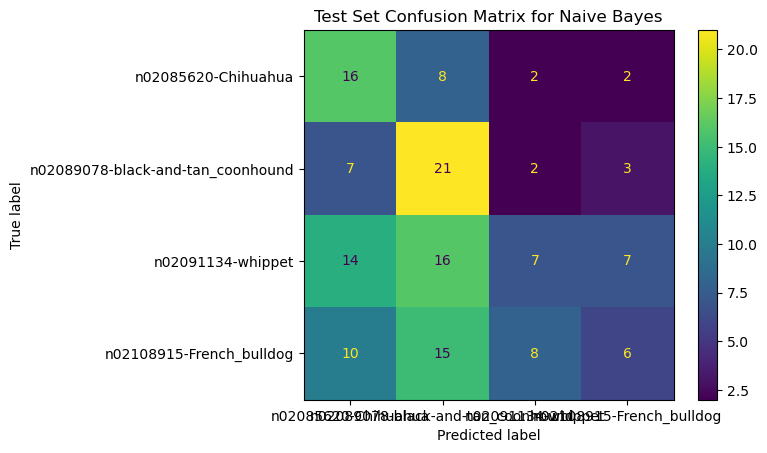

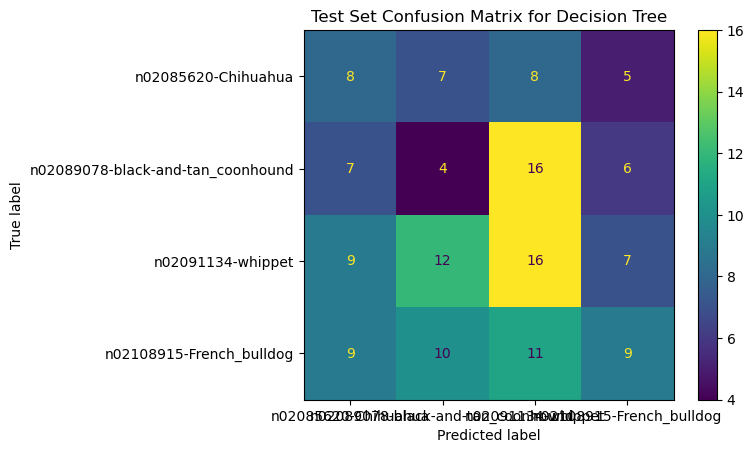

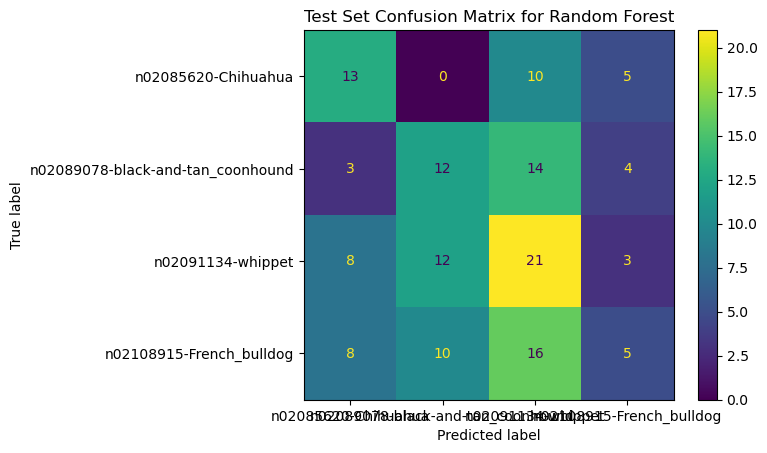

Cross-Validation Mean Accuracies:
Naive Bayes: 0.32
Decision Tree: 0.30
Random Forest: 0.37

Test Set Accuracies:
Naive Bayes: 0.35
Decision Tree: 0.26
Random Forest: 0.35

F1 Scores on Test Set:
Naive Bayes: 0.31
Decision Tree: 0.26
Random Forest: 0.34


In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt


classifiers = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

# Performing the stratified 5-fold cross-validation and collecting metrics
skf = StratifiedKFold(n_splits=5)
cv_accuracies = {}
test_accuracies = {}
f1_scores = {}


for name, clf in classifiers.items():
    y_true_all = []
    y_pred_all = []
    fold_accuracies = []
    
    for train_index, test_index in skf.split(std_X_train, y_train):
        X_fold_train, X_fold_test = std_X_train[train_index], std_X_train[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]
    
        clf.fit(X_fold_train, y_fold_train)
    
        y_pred = clf.predict(X_fold_test)
        fold_accuracy = accuracy_score(y_fold_test, y_pred)
        fold_accuracies.append(fold_accuracy)
        
        y_true_all.extend(y_fold_test)
        y_pred_all.extend(y_pred)
    

    cv_accuracies[name] = sum(fold_accuracies) / len(fold_accuracies)

    clf.fit(std_X_train, y_train)  
    y_test_pred = clf.predict(std_X_test) 

    test_accuracies[name] = accuracy_score(y_test, y_test_pred)
    f1_scores[name] = f1_score(y_test, y_test_pred, average='weighted')
  
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"Test Set Confusion Matrix for {name}")
    plt.show()

print("Cross-Validation Mean Accuracies:")
for name, acc in cv_accuracies.items():
    print(f"{name}: {acc:.2f}")

print("\nTest Set Accuracies:")
for name, acc in test_accuracies.items():
    print(f"{name}: {acc:.2f}")

print("\nF1 Scores on Test Set:")
for name, f1 in f1_scores.items():
    print(f"{name}: {f1:.2f}")

#### 6b. The confusion matrix for Naive Bayes showed the lightest diagonal values and the darkest off-diagonal color, suggesting it performed well in classifying most samples correctly.

#### 6c. Best Method among the three classifiers is Random Forest & had the highest mean validation accuracy of 0.37, indicating that it generalized well during cross-validation.

#### 6d. Best Method among the three classifiers is Naive Bayes & had the highest test set accuracy of 0.35, suggesting it performed best on new data.

#### 6e. Best Method among the three classifiers is Naive Bayes & Random forest equals the F1 Score of 0.31, considers both with the best F1 Scores. 

# 7. Model Selection

In [47]:
classes = ['n02108915-French_bulldog', 'n02085620-Chihuahua']
# i. Using images from two classes

class_wise_images = {}
parent_folder = os.path.join(os.getcwd(), 'Cropped')
for class_name in classes:
    class_folder = os.path.join(parent_folder, class_name)
    class_wise_images[class_name] = [os.path.join(class_folder, image_file_name) for image_file_name in os.listdir(class_folder)]
    

# ii. Edge Histograms
def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)


histograms = []
labels = []
for class_name in classes:
    for img in class_wise_images[class_name]:
        I = rgb2gray(Image.open(img))
        angle_sobel = angle(filters.sobel_h(I), filters.sobel_v(I))
        hist, bin_centers = ski.exposure.histogram(angle_sobel, nbins=36)
        histograms.append(hist)
        labels.append(class_name)

histograms = np.array(histograms)
labels = np.array(labels)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(histograms, labels, test_size=0.20, random_state=42)

In [49]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((257, 36), (65, 36), (257,), (65,))

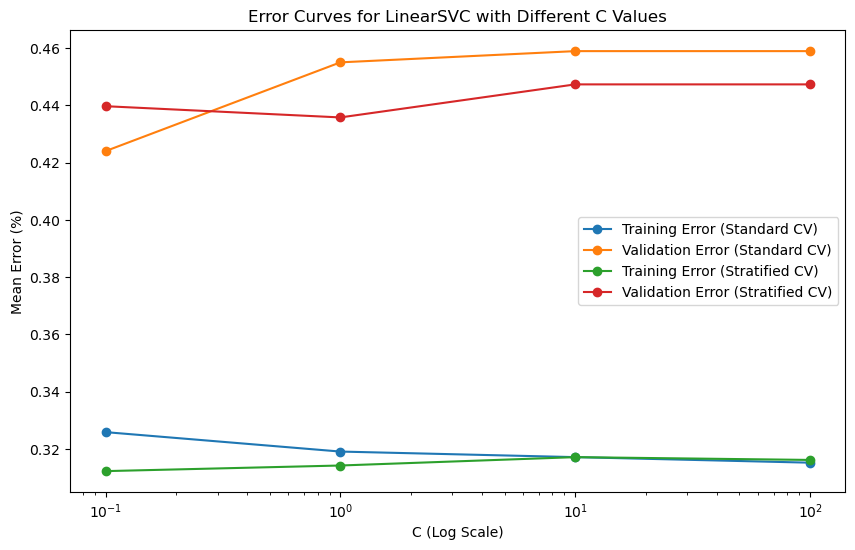

Best C value (lowest mean validation error, Stratified CV): 1
Test Error with C=1: 55.38%


In [50]:
scaler = StandardScaler()
std_X_train = scaler.fit_transform(X_train)
std_X_test = scaler.transform(X_test)

C_values = [0.1, 1, 10, 100]
training_errors_standard = []
validation_errors_standard = []
training_errors_stratified = []
validation_errors_stratified = []

for C in C_values:
    clf = LinearSVC(C=C, max_iter=10000)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_errors = []
    val_errors = []
    
    for train_index, val_index in kf.split(std_X_train):
        X_fold_train, X_fold_val = std_X_train[train_index], std_X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        clf.fit(X_fold_train, y_fold_train)
        train_error = 1 - accuracy_score(y_fold_train, clf.predict(X_fold_train))
        val_error = 1 - accuracy_score(y_fold_val, clf.predict(X_fold_val))
        
        train_errors.append(train_error)
        val_errors.append(val_error)
    
    training_errors_standard.append(np.mean(train_errors))
    validation_errors_standard.append(np.mean(val_errors))
 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    strat_train_errors = []
    strat_val_errors = []
    
    for train_index, val_index in skf.split(std_X_train, y_train):
        X_fold_train, X_fold_val = std_X_train[train_index], std_X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        clf.fit(X_fold_train, y_fold_train)
        strat_train_error = 1 - accuracy_score(y_fold_train, clf.predict(X_fold_train))
        strat_val_error = 1 - accuracy_score(y_fold_val, clf.predict(X_fold_val))
        
        strat_train_errors.append(strat_train_error)
        strat_val_errors.append(strat_val_error)
    
    training_errors_stratified.append(np.mean(strat_train_errors))
    validation_errors_stratified.append(np.mean(strat_val_errors))

plt.figure(figsize=(10, 6))
plt.plot(C_values, training_errors_standard, label='Training Error (Standard CV)', marker='o')
plt.plot(C_values, validation_errors_standard, label='Validation Error (Standard CV)', marker='o')
plt.plot(C_values, training_errors_stratified, label='Training Error (Stratified CV)', marker='o')
plt.plot(C_values, validation_errors_stratified, label='Validation Error (Stratified CV)', marker='o')
plt.xscale('log')
plt.xlabel('C (Log Scale)')
plt.ylabel('Mean Error (%)')
plt.title('Error Curves for LinearSVC with Different C Values')
plt.legend()
plt.show()

best_C_index = np.argmin(validation_errors_stratified)
best_C = C_values[best_C_index]
print(f"Best C value (lowest mean validation error, Stratified CV): {best_C}")


final_clf = LinearSVC(C=best_C, max_iter=10000)
final_clf.fit(std_X_train, y_train)
test_error = 1 - accuracy_score(y_test, final_clf.predict(std_X_test))
print(f"Test Error with C={best_C}: {test_error * 100:.2f}%")